# Dad Music Classifier

## Imports

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve)

## Global Variables

In [ ]:
seed = 42 # Keeping the seed as 42 for better reproducability
use_gpu_if_available = True # Can utilize cuda for faster training, otherwise use cpu

device = torch.device('cuda' if ( torch.cuda.is_available() and use_gpu_if_available ) else 'cpu')
print('Using device:', device)

Using device: cuda


## Classifier

### Load Data

In [ ]:
# Load and clean the data
df = pd.read_csv(rf'data.csv')

# The data is slightly imbalanced... there is roughly 33% more dad music in the data, so the model would be biased towards classifying a song as dad music without resampling
df_majority = df[df['is_dad_music'] == 1]
df_minority = df[df['is_dad_music'] == 0]

df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=seed)
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Separate features and target
X = df_balanced.drop(columns=['is_dad_music']).values
y = df_balanced['is_dad_music'].values

# Split off the training data (70% of the total data)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

# Split the remaining data into a validation set and test set (15% of the total data each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed, stratify=y_temp)

# Convert to PyTorch tensors
train_X = torch.tensor(X_train, dtype=torch.float32)
train_y = torch.tensor(y_train, dtype=torch.float32)

val_X = torch.tensor(X_val, dtype=torch.float32)
val_y = torch.tensor(y_val, dtype=torch.float32)

test_X = torch.tensor(X_test, dtype=torch.float32)
test_y = torch.tensor(y_test, dtype=torch.float32)

# Use the device specified by the global variable ('cuda' for faster training, or 'cpu' if cuda isn't available)
train_X = train_X.to(device)
train_y = train_y.to(device)

val_X = val_X.to(device)
val_y = val_y.to(device)

test_X = test_X.to(device)
test_y = test_y.to(device)
print('Data sent to:', device)

Data sent to: cuda


### Model Class

In [ ]:
'''
I'm using a neural net with 4 layers, it takes in 10 input features, normalizes them with BatchNorm1d,
then passes them to a layer with 128 nodes. I use a ReLU activation function, BatchNorm1d, and Dropout after
each hidden layer, until it is passed to the final output layer, which condenses the 16 features into 1, and
uses Sigmoid to get a value between 0 and 1 representing the probability that the song is dad music. The larger
the value, the more confident the model is that the song is dad music. Any probability below 0.5 is labeled as
NOT dad music, and any probability 0.5 or higher is labeled as dad music.

The network has the following structure: 10 input features -> 128 -> 32 -> 16 -> 1 (probability between 0 and 1
that the song is dad music).
'''

class DadMusicClassifier(nn.Module):
    def __init__(self):
        super(DadMusicClassifier, self).__init__()

        self.network = nn.Sequential(

            nn.BatchNorm1d(10), # Normalize the inputs since I don't do any preprocessing
            nn.Linear( in_features = 10, out_features = 128 ),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),


            nn.Linear( in_features = 128, out_features = 32 ),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.5),


            nn.Linear( in_features = 32, out_features = 16 ),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Dropout(0.5),


            nn.Linear( in_features = 16, out_features = 1 ),
            nn.Sigmoid() # Ensure the final values are between 0 and 1

        )

    def forward(self, input_tensor):
        return self.network(input_tensor)

### Training Function

In [ ]:
def train_model(train_X, train_y, val_X, val_y, model, num_epochs=50, batch_size=32, alpha=0.001, weight_decay=0.0005):

    loss_function = nn.BCELoss() # It is a binary classification... dad music or not dad music, so BCELoss

    optimizer = optim.Adam( model.parameters(), lr = alpha, weight_decay=weight_decay )

    # Utilize DataLoader to get batches
    train_dataset = TensorDataset( train_X, train_y )
    train_loader = DataLoader ( train_dataset, batch_size, shuffle=True )

    val_dataset = TensorDataset( val_X, val_y )
    val_loader = DataLoader ( val_dataset, batch_size, shuffle=True )

    print(f'Epoch\t\tTrain Loss\t\t Val Loss\t\t Train Acc\t\t  Val Acc')

    # Training loop
    for epoch in range(num_epochs):

        total_train_loss = 0
        model.train()

        for X_batch_train, y_batch_train in train_loader:

            optimizer.zero_grad()

            outputs = model( X_batch_train ).squeeze()

            train_loss = loss_function( outputs, y_batch_train )

            train_loss.backward()

            optimizer.step()

            total_train_loss += train_loss.item()

        model.eval()

        # Get the validation loss and the accuracies to display
        with torch.no_grad():

            total_val_loss = 0

            for X_batch_val, y_batch_val in val_loader:
                val_outputs = model( X_batch_val ).squeeze()
                total_val_loss += loss_function( val_outputs, y_batch_val ).item()

            train_accuracy = ( torch.sum( torch.abs( model( train_X ).squeeze() - train_y ) < 0.5 ) / ( train_y.shape[0] ) ).item()
            val_accuracy = ( torch.sum( torch.abs( model( val_X ).squeeze() - val_y ) < 0.5 ) / ( val_y.shape[0] ) ).item()

        # Display the losses and the accuracies
        print(f'{epoch+1}/{num_epochs} \t {total_train_loss:17.4f} \t {total_val_loss:16.4f} \t {train_accuracy:17.4f} \t {val_accuracy:16.4f}')

### Evaluation Function

In [ ]:
def evaluate_model(model, X_tensor, y_tensor, plot_roc=True, title="Model Evaluation"):
    model.eval()
    with torch.no_grad():
        y_probs = model(X_tensor).squeeze()
        y_preds = (y_probs >= 0.5).int()

    y_true = y_tensor.int().cpu().numpy()
    y_preds_np = y_preds.cpu().numpy()
    y_probs_np = y_probs.cpu().numpy()

    # Compute metrics
    accuracy = accuracy_score(y_true, y_preds_np)
    precision = precision_score(y_true, y_preds_np)
    recall = recall_score(y_true, y_preds_np)
    f1 = f1_score(y_true, y_preds_np)
    roc_auc = roc_auc_score(y_true, y_probs_np)
    conf_matrix = confusion_matrix(y_true, y_preds_np)

    # Print metrics
    print(f"{title}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    print("Confusion Matrix:\n", conf_matrix)

    # Plot ROC Curve
    if plot_roc:
        fpr, tpr, _ = roc_curve(y_true, y_probs_np)
        plt.figure()
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.grid(True)
        plt.show()

def evaluate_model_compare(model, X_tensor_1, X_tensor_2, y_tensor_1, y_tensor_2, title="Model Evaluation"):
    model.eval()
    with torch.no_grad():
        y_probs_1 = model(X_tensor_1).squeeze()
        y_preds_1 = (y_probs_1 >= 0.5).int()

        y_probs_2 = model(X_tensor_2).squeeze()
        y_preds_2 = (y_probs_2 >= 0.5).int()

    y_true_1 = y_tensor_1.int().cpu().numpy()
    y_preds_1_np = y_preds_1.cpu().numpy()
    y_probs_1_np = y_probs_1.cpu().numpy()

    y_true_2 = y_tensor_2.int().cpu().numpy()
    y_preds_2_np = y_preds_2.cpu().numpy()
    y_probs_2_np = y_probs_2.cpu().numpy()

    # Compute metrics
    accuracy_1 = accuracy_score(y_true_1, y_preds_1_np)
    precision_1 = precision_score(y_true_1, y_preds_1_np)
    recall_1 = recall_score(y_true_1, y_preds_1_np)
    f1_1 = f1_score(y_true_1, y_preds_1_np)
    roc_auc_1 = roc_auc_score(y_true_1, y_probs_1_np)
    conf_matrix_1 = confusion_matrix(y_true_1, y_preds_1_np)

    accuracy_2 = accuracy_score(y_true_2, y_preds_2_np)
    precision_2 = precision_score(y_true_2, y_preds_2_np)
    recall_2 = recall_score(y_true_2, y_preds_2_np)
    f1_2 = f1_score(y_true_2, y_preds_2_np)
    roc_auc_2 = roc_auc_score(y_true_2, y_probs_2_np)
    conf_matrix_2 = confusion_matrix(y_true_2, y_preds_2_np)

    # Print metrics
    print(f"{title}")
    print("             Train  vs.  Validation")
    print(f"Accuracy:    {accuracy_1:.4f} \t {accuracy_2:.4f}")
    print(f"Precision:   {precision_1:.4f} \t {precision_2:.4f}")
    print(f"Recall:      {recall_1:.4f} \t {recall_2:.4f}")
    print(f"F1 Score:    {f1_1:.4f} \t {f1_2:.4f}")
    print(f"ROC-AUC:     {roc_auc_1:.4f} \t {roc_auc_2:.4f}")
    print("\nConfusion Matrices:")
    print("Train:\n", conf_matrix_1)
    print("Validation:\n", conf_matrix_2)

## Training

In [12]:
model = DadMusicClassifier()
model.to( device = device )

DadMusicClassifier(
  (network): Sequential(
    (0): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=10, out_features=128, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=128, out_features=32, bias=True)
    (6): ReLU()
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=32, out_features=16, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Dropout(p=0.5, inplace=False)
    (13): Linear(in_features=16, out_features=1, bias=True)
    (14): Sigmoid()
  )
)

In [13]:
num_epochs = 50
batch_size = 32
alpha = 0.001
weight_decay = 0.0005

train_model(train_X, train_y, val_X, val_y, model, num_epochs, batch_size, alpha, weight_decay)
print("")
evaluate_model_compare(model, train_X, val_X, train_y, val_y)

Epoch		Train Loss		 Val Loss		 Train Acc		  Val Acc
1/50 	           38.9428 	           6.5652 	            0.8939 	           0.8227
2/50 	           27.0857 	           4.9884 	            0.9202 	           0.8659
3/50 	           22.0794 	           4.0983 	            0.9372 	           0.8932
4/50 	           21.0446 	           3.7193 	            0.9367 	           0.8955
5/50 	           17.8256 	           3.6946 	            0.9353 	           0.9023
6/50 	           17.7534 	           3.3455 	            0.9416 	           0.9136
7/50 	           17.9584 	           3.4142 	            0.9416 	           0.9068
8/50 	           17.4031 	           3.2809 	            0.9426 	           0.9091
9/50 	           16.9024 	           3.1108 	            0.9445 	           0.9045
10/50 	           16.0428 	           3.2917 	            0.9411 	           0.9091
11/50 	           16.3749 	           3.0552 	            0.9445 	           0.9068
12/50 	           15.0775 	      

### Evaluate Model on Test Set

Test Set Evaluation
Accuracy:  0.9478
Precision: 0.9498
Recall:    0.9455
F1 Score:  0.9476
ROC-AUC:   0.9831
Confusion Matrix:
 [[210  11]
 [ 12 208]]


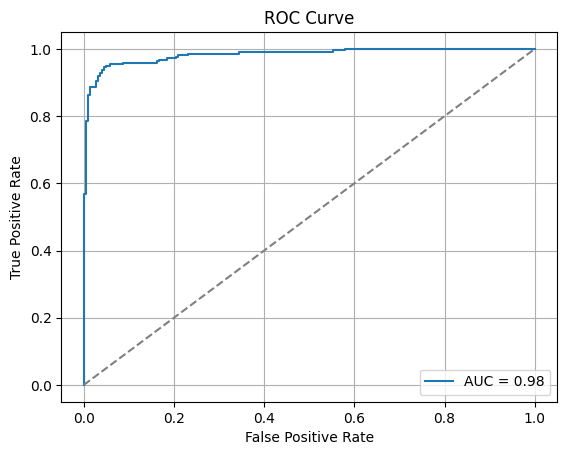

In [14]:
evaluate_model(model, test_X, test_y, title="Test Set Evaluation")

In [15]:
torch.save(model.state_dict(), "model_dad_classifier_trained")

## Load Trained Model

In [23]:
model = DadMusicClassifier()
model.to( device = device )

model.load_state_dict(torch.load( "model_dad_classifier_trained" ))

<All keys matched successfully>

### Evaluate Model on Test Set

Test Set Evaluation
Accuracy:  0.9478
Precision: 0.9498
Recall:    0.9455
F1 Score:  0.9476
ROC-AUC:   0.9831
Confusion Matrix:
 [[210  11]
 [ 12 208]]


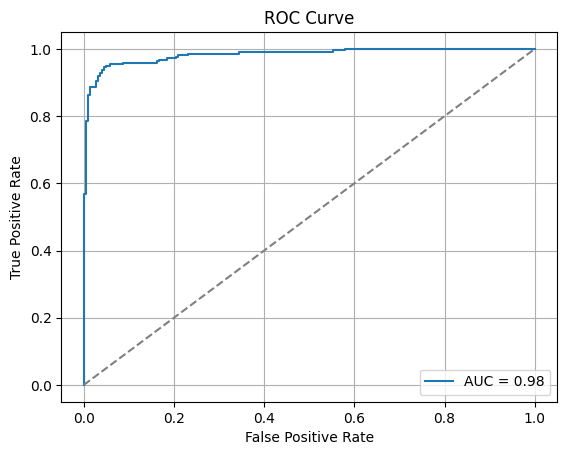

In [24]:
evaluate_model(model, test_X, test_y, title="Test Set Evaluation")